# **Part 1:** Data Preparation (Ching-min & Dandan)##

Chosen Superclass: Small mammals and Medium-sized mammals.

In [0]:
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.osuosl.org/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xf spark-2.4.4-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"


Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:5 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:10 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease [15.4 kB]
Get:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:14 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic/main Sources [1,741

In [0]:
#1 Code to read csv file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [0]:
# Import the necessary packages
%%time
import findspark
findspark.init(os.environ["SPARK_HOME"])# SPARK_HOME
from pyspark.sql.types import Row
from pyspark.ml.linalg import Vectors, DenseVector
from pyspark.ml.feature import StringIndexer
from pyspark.sql import SparkSession
import numpy as np
import json


CPU times: user 241 ms, sys: 14.2 ms, total: 255 ms
Wall time: 263 ms


In [0]:
# Increase the memory limit/maximum memory configuration - https://datascience.stackexchange.com/questions/8549/how-do-i-set-get-heap-size-for-spark-via-python-notebook
#spark = SparkSession.builder.master("local[*]").getOrCreate()
%%time
Memory_limit = "12g"
spark = SparkSession.builder.appName("Foo").config("spark.executor.memory", Memory_limit).config("spark.driver.memory", Memory_limit).getOrCreate()
#spark = SparkSession.builder.appName("App").config("spark.executor.memory", Memory_limit).config("spark.driver.memory", Memory_limit)\
        #.config("spark.driver.maxResultSize", '10G').config('spark.executor.cores', '2').config("spark.driver.cores","4").config("spark.num.executors","4").getOrCreate()

"""https://www.edureka.co/community/5268/how-to-change-the-spark-session-configuration-in-pyspark
config = pyspark.SparkConf().setAll([('spark.executor.memory', '12g'), ('spark.executor.cores', '3'), ('spark.cores.max', '3'), ('spark.driver.memory','12g')])
sc.stop()
sc = pyspark.SparkContext(conf=config)"""


CPU times: user 29.2 ms, sys: 9.71 ms, total: 38.9 ms
Wall time: 5.72 s


## **Download data**

In [0]:
#2. Get the file
# Make sure you upload all your data files to your Google drive and change share->Advanced->change->anyone with the link can view
%%time
downloaded1 = drive.CreateFile({'id': '1YoyOoPty-a3i8oMStdheWrDTCKrcONG3'}) # replace the id with id of file you want to access
downloaded1.GetContentFile('train')
downloaded2 = drive.CreateFile({'id':'1Qe_Z5HGgdF2_c8XoypiCIGutK6wAvb8e'}) # replace the id with id of file you want to access
downloaded2.GetContentFile('test')
downloaded3 = drive.CreateFile({'id':'1eqHqAAOx0OuMhnpgTkBlvUPx9eGH0snZ'}) # replace the id with id of file you want to access
downloaded3.GetContentFile('meta')

CPU times: user 328 ms, sys: 680 ms, total: 1.01 s
Wall time: 8.96 s


In [0]:
# Unpickle the file
%%time
import pickle

def unpickle(file):
    with open(file, 'rb') as fo:
        dic = pickle.load(fo, encoding='bytes')
    return dic

# Fetch the Train data
datatrain = unpickle('train')

# Fetch the test data
datatest = unpickle('test')

# Fetch the metadata
datameta = unpickle("meta")

# Convert the data type from byte to utf-8
fine_labels = [x.decode('utf-8')for x in datameta.get(b'fine_label_names')]
print(fine_labels)
coarse_labels = [x.decode('utf-8')for x in datameta.get(b'coarse_label_names')]
print(coarse_labels)

['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree',

In [0]:
# Generate the train data RDD
%%time
cifar_train_RDD = spark.sparkContext.parallelize(list(zip( \
    [name.decode('utf-8') for name in datatrain.get(b'filenames')],\
    datatrain.get(b'fine_labels'), datatrain.get(b'coarse_labels'), \
    datatrain.get(b'data'))))
print (cifar_train_RDD.count())
cifar_train_RDD.map(lambda x: x[3]).take(1)

50000
CPU times: user 468 ms, sys: 254 ms, total: 722 ms
Wall time: 3.88 s


In [0]:
# Generate the test data RDD
%%time
cifar_test_RDD = spark.sparkContext.parallelize(list(zip( \
    [name.decode('utf-8') for name in datatest.get(b'filenames')],\
    datatest.get(b'fine_labels'), datatest.get(b'coarse_labels'), \
    datatest.get(b'data'))))
print (cifar_test_RDD.count())

10000
CPU times: user 101 ms, sys: 38.8 ms, total: 140 ms
Wall time: 478 ms


## **Combine the training RDD and test RDD into one RDD**

In [0]:
# Combine the train RDD and test RDD into one RDD, may take a long while to run
%%time
combine_rdd = cifar_train_RDD.union(cifar_test_RDD)
print (combine_rdd.count())

60000
CPU times: user 6.44 ms, sys: 2.65 ms, total: 9.1 ms
Wall time: 1.2 s


Seed is used to save the state of the random function in subsequent executions.

In [0]:
# Take a sample from the data
%%time
print (combine_rdd.takeSample(withReplacement=False, num=5, seed=123))

[('power_mower_s_000260.png', 41, 19, array([255, 242, 202, ..., 255, 252, 252], dtype=uint8)), ('bicycle_s_002728.png', 8, 18, array([0, 0, 0, ..., 4, 4, 6], dtype=uint8)), ('sunflower_s_000513.png', 82, 2, array([36, 43, 47, ..., 84, 90, 70], dtype=uint8)), ('poppy_s_001505.png', 62, 2, array([4, 4, 4, ..., 7, 7, 8], dtype=uint8)), ('rosebush_s_001692.png', 70, 2, array([23, 24, 26, ..., 66, 68, 68], dtype=uint8))]
CPU times: user 14.1 ms, sys: 3.19 ms, total: 17.3 ms
Wall time: 1.93 s


Here, we convert the RDD into Dataframe and normalize the image data by dividing it with the largest pixel value, which is 255.

In [0]:
# Convert the combined RDD into spark dataframe and normalize
%%time
combine_df = spark.createDataFrame(combine_rdd.map(lambda x: Row(filenames=x[0], fine_labels=int(x[1]), coarse_labels=int(x[2]), data=DenseVector(x[3])/255.0)) )
print (combine_df.count())

60000
CPU times: user 25.9 ms, sys: 5.35 ms, total: 31.2 ms
Wall time: 1min 56s


In [0]:
# Print the first 10 rows
%%time
combine_df.show()

+-------------+--------------------+--------------------+-----------+
|coarse_labels|                data|           filenames|fine_labels|
+-------------+--------------------+--------------------+-----------+
|           11|[1.0,1.0,1.0,1.0,...|bos_taurus_s_0005...|         19|
|           15|[1.0,0.9921568627...|stegosaurus_s_000...|         29|
|            4|[0.98039215686274...|mcintosh_s_000643...|          0|
|           14|[0.48627450980392...|altar_boy_s_00143...|         11|
|            1|[0.16862745098039...|cichlid_s_000031.png|          1|
|            5|[0.74509803921568...|  phone_s_002161.png|         86|
|           18|[0.19607843137254...|car_train_s_00004...|         90|
|            3|[0.69803921568627...| beaker_s_000604.png|         28|
|           10|[0.47843137254901...|    fog_s_000397.png|         23|
|           11|[1.0,1.0,1.0,1.0,...|rogue_elephant_s_...|         31|
|            5|[0.32549019607843...|computer_keyboard...|         39|
|           17|[0.99

## **Filter out the assigned superclasses**

In [0]:
# Get the index of ten classes of animals
%%time
#medium_sized_mammals_index = [ fine_labels.index(x) for x in ['fox', 'porcupine', 'possum', 'raccoon', 'skunk'] ]
#small_mammals_index = [ fine_labels.index(x) for x in ['hamster', 'mouse', 'rabbit', 'shrew', 'squirrel'] ]

medium_sized_mammals_index = [ coarse_labels.index(x) for x in ['medium_mammals'] ]
small_mammals_index = [ coarse_labels.index(x) for x in ['small_mammals'] ]

target_index = medium_sized_mammals_index + small_mammals_index
print (medium_sized_mammals_index, small_mammals_index)
print(target_index)

[12] [16]
[12, 16]
CPU times: user 1.17 ms, sys: 0 ns, total: 1.17 ms
Wall time: 3.27 ms


In [0]:
# Verify the label number
%%time
for ind in target_index:
  print ("Index", ind, "is for coarse label:", coarse_labels[ind])

Index 12 is for coarse label: medium_mammals
Index 16 is for coarse label: small_mammals
CPU times: user 2.05 ms, sys: 11 µs, total: 2.06 ms
Wall time: 2.99 ms


In [0]:
# Filter out the assigned ten fine classes, reorder columns and check the count
%%time
from pyspark.sql.functions import col

target_df = combine_df.filter(col('coarse_labels').isin(target_index))                 # Can do combine_df.filter((combine_df['coarse_labels']==12) | (combine_df['coarse_labels']==16))
target_df = target_df.select("data","coarse_labels","fine_labels","filenames")

print ("Count:", target_df.count())

Count: 6000
CPU times: user 17.7 ms, sys: 4.36 ms, total: 22 ms
Wall time: 1min 54s


In [0]:
# Import packages
%%time
from pyspark.sql.functions import udf, rand
from pyspark.sql.types import StringType
from pyspark.sql.types import FloatType
from pyspark.mllib.linalg import VectorUDT

CPU times: user 11.8 ms, sys: 2.84 ms, total: 14.6 ms
Wall time: 20.1 ms


In [0]:
# Add two columns fine label as fine and coarse label as coarse
%%time
target_name_df = target_df.withColumn("coarse", udf(lambda coarse_label: coarse_labels[coarse_label], StringType())(target_df['coarse_labels'])) \
    .withColumn("fine", udf(lambda fine_label: fine_labels[fine_label], StringType())(target_df['fine_labels']))

CPU times: user 14.2 ms, sys: 0 ns, total: 14.2 ms
Wall time: 51.7 ms


In [0]:
# Display the statistical features of the data
%%time
target_name_df.describe().show()

+-------+-----------------+------------------+--------------------+--------------+--------+
|summary|    coarse_labels|       fine_labels|           filenames|        coarse|    fine|
+-------+-----------------+------------------+--------------------+--------------+--------+
|  count|             6000|              6000|                6000|          6000|    6000|
|   mean|             14.0|              60.7|                null|          null|    null|
| stddev|2.000166687502895|15.014911741191348|                null|          null|    null|
|    min|               12|                34|american_water_sh...|medium_mammals|     fox|
|    max|               16|                80|water_shrew_s_000...| small_mammals|squirrel|
+-------+-----------------+------------------+--------------------+--------------+--------+

CPU times: user 12.5 ms, sys: 6.07 ms, total: 18.6 ms
Wall time: 1min 54s


In [0]:
# Print the first 3 rows
%%time
target_name_df.show(3)

+--------------------+-------------+-----------+--------------------+--------------+--------+
|                data|coarse_labels|fine_labels|           filenames|        coarse|    fine|
+--------------------+-------------+-----------+--------------------+--------------+--------+
|[0.27843137254901...|           16|         80|squirrel_s_002467...| small_mammals|squirrel|
|[0.61176470588235...|           16|         74|  shrew_s_002233.png| small_mammals|   shrew|
|[0.96078431372549...|           12|         64|opossum_s_001237.png|medium_mammals|  possum|
+--------------------+-------------+-----------+--------------------+--------------+--------+
only showing top 3 rows

CPU times: user 5.37 ms, sys: 2.29 ms, total: 7.66 ms
Wall time: 46.3 s


# **Visualize and validate the data**

In [0]:
# Generate sample data randomly
%%time
fractions = dict()
for fine in ['fox', 'porcupine', 'possum', 'raccoon', 'skunk', 'hamster', 'mouse', 'rabbit', 'shrew', 'squirrel']:
  fractions[fine] = 0.02                              

sample_df = target_name_df.sampleBy('fine', fractions)
print(sample_df.count())

138
CPU times: user 16.4 ms, sys: 2.81 ms, total: 19.2 ms
Wall time: 1min 52s


In [0]:
# Generate the samples list
%%time
samples = sample_df.select('coarse', 'fine', 'data').orderBy('coarse', 'fine').rdd.collect()

CPU times: user 88.2 ms, sys: 8.83 ms, total: 97 ms
Wall time: 3min 45s


CPU times: user 630 ms, sys: 18 ms, total: 648 ms
Wall time: 663 ms


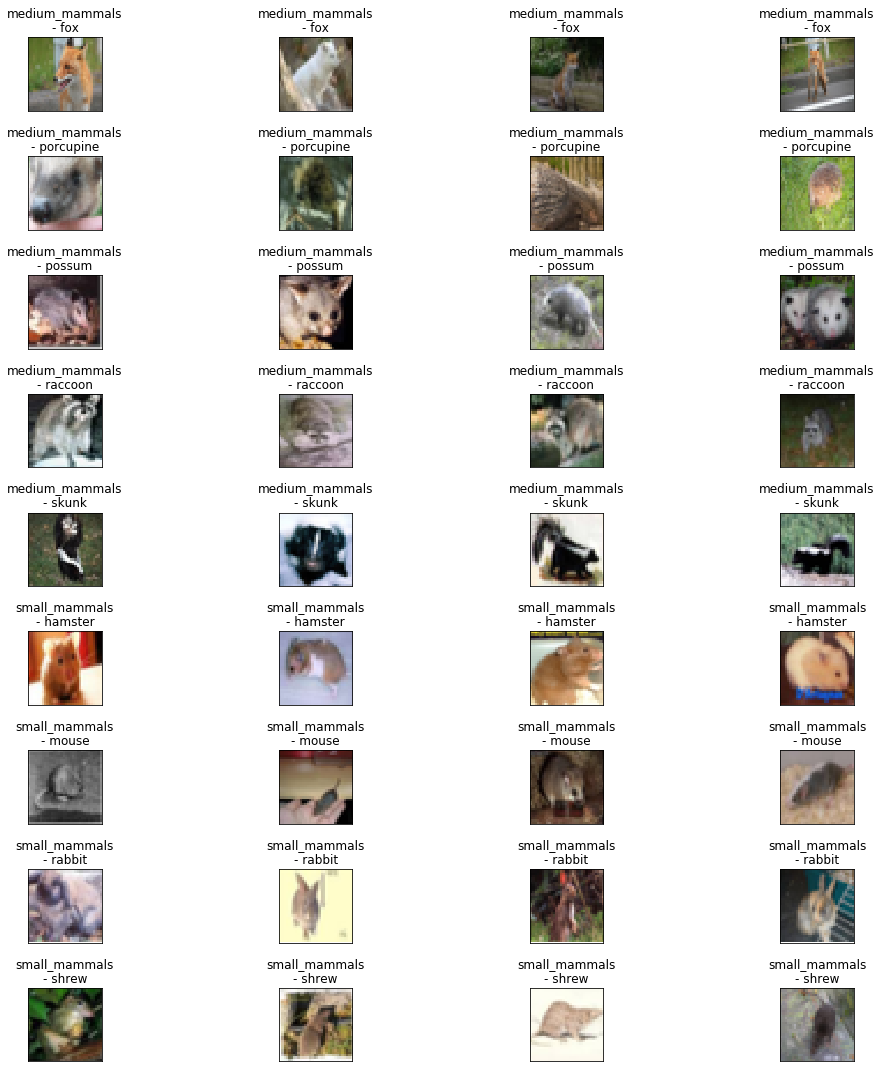

In [0]:
# Visualize the data
%%time
import matplotlib.pyplot as plt

# initialize the dict, the key is the ten fine class, the count is 0
counts = dict.fromkeys(['fox', 'porcupine', 'possum', 'raccoon', 'skunk', 'hamster', 'mouse', 'rabbit', 'shrew', 'squirrel'], 0) 

fig = plt.figure(figsize=(15, 15))
index = 1
for sample in samples:
  counts[sample.fine] += 1
  if counts[sample.fine] > 4:
    continue
  
  img = sample.data.reshape(3,32,32).transpose([1, 2, 0])
  fig.add_subplot(9, 4, index, xticks=[], yticks=[])
  plt.imshow(img)
  plt.title("{}\n- {}".format(sample.coarse, sample.fine))
  index += 1
  if index > 36:
    break

fig.set_tight_layout(True)


#**Prediction on randomly selected testing images**
##  **Pre-requisite:** Process and verify training and testing set (Megha & Rajasree)## 

This step is important as Pyspark's ML algorithms tend to have a specified format for input features and labels.

In [0]:
# Change the coarse label into a binary label
%%time
stringindexer = StringIndexer(inputCol='coarse_labels', outputCol='binary_index')
target_name_df = stringindexer.fit(target_name_df).transform(target_name_df)

# Select the distinct binary indices
print ("Distinct binary indices:", target_name_df.select('binary_index').distinct().collect() )

Distinct binary indices: [Row(binary_index=0.0), Row(binary_index=1.0)]
CPU times: user 57.3 ms, sys: 16.3 ms, total: 73.7 ms
Wall time: 3min 46s


In [0]:
# Rename data as features and re-order columns 
%%time
target_name_df = target_name_df.withColumnRenamed("data","features").select("features","binary_index", "coarse_labels","coarse","fine_labels","fine")

CPU times: user 1.85 ms, sys: 3.71 ms, total: 5.56 ms
Wall time: 33.7 ms


In [0]:
# Verify the data type
%%time
target_name_df.dtypes

CPU times: user 1.71 ms, sys: 0 ns, total: 1.71 ms
Wall time: 17.1 ms


[('features', 'vector'),
 ('binary_index', 'double'),
 ('coarse_labels', 'bigint'),
 ('coarse', 'string'),
 ('fine_labels', 'bigint'),
 ('fine', 'string')]

In [0]:
# Check for null values in each column
%%time
for c in target_name_df.columns: 
  print ("Column",c, "- no.of null values:", target_name_df.where(col(c).isNull()).count()) 

Column features - no.of null values: 0
Column binary_index - no.of null values: 0
Column coarse_labels - no.of null values: 0
Column coarse - no.of null values: 0
Column fine_labels - no.of null values: 0
Column fine - no.of null values: 0
CPU times: user 70.7 ms, sys: 16 ms, total: 86.7 ms
Wall time: 9min 24s


Here, we randomly select 80% of data as training data and remaining 20% data as testing data. Seed is used to save the state of the random function in subsequent executions.

In [0]:
# Split randomly into training set and testing set
%%time
train_df, test_df = target_name_df.randomSplit([0.80,0.20], seed=1369)

CPU times: user 1.98 ms, sys: 1.56 ms, total: 3.53 ms
Wall time: 23.6 ms


In [0]:
# Count the number of entries in training and testing data
%%time
print ("Training set count:", train_df.count(), \
       "\nTesting set count:", test_df.count())

Training set count: 4857 
Testing set count: 1143
CPU times: user 24.2 ms, sys: 5.89 ms, total: 30.1 ms
Wall time: 3min 47s


In [0]:
# Check the distinct labels
%%time
print("Distinct labels in the training set -", train_df.select('coarse_labels','binary_index','coarse').distinct().collect(),\
      "\nDistinct labels in the testing set -", train_df.select('coarse_labels','binary_index','coarse').distinct().collect())

Distinct labels in the training set - [Row(coarse_labels=16, binary_index=0.0, coarse='small_mammals'), Row(coarse_labels=12, binary_index=1.0, coarse='medium_mammals')] 
Distinct labels in the testing set - [Row(coarse_labels=16, binary_index=0.0, coarse='small_mammals'), Row(coarse_labels=12, binary_index=1.0, coarse='medium_mammals')]
CPU times: user 77.1 ms, sys: 24.9 ms, total: 102 ms
Wall time: 3min 50s


## Study the training data

In [0]:
# Verify the training set file type
%%time
print ("Training data - Type", type(train_df))

Training data - Type <class 'pyspark.sql.dataframe.DataFrame'>
CPU times: user 1.21 ms, sys: 0 ns, total: 1.21 ms
Wall time: 3.41 ms


In [0]:
# Verify the Schema
%%time
train_df.printSchema()

root
 |-- features: vector (nullable = true)
 |-- binary_index: double (nullable = false)
 |-- coarse_labels: long (nullable = true)
 |-- coarse: string (nullable = true)
 |-- fine_labels: long (nullable = true)
 |-- fine: string (nullable = true)

CPU times: user 1.53 ms, sys: 0 ns, total: 1.53 ms
Wall time: 3.66 ms


In [0]:
# Display the statistical features 
%%time
train_df.describe().show()

+-------+------------------+------------------+--------------+-----------------+--------+
|summary|      binary_index|     coarse_labels|        coarse|      fine_labels|    fine|
+-------+------------------+------------------+--------------+-----------------+--------+
|  count|              4857|              4857|          4857|             4857|    4857|
|   mean|0.4968087296685197|14.012765081325922|          null| 60.6438130533251|    null|
| stddev|0.5000412946929902|2.0001651787719608|          null|15.04927242806568|    null|
|    min|               0.0|                12|medium_mammals|               34|     fox|
|    max|               1.0|                16| small_mammals|               80|squirrel|
+-------+------------------+------------------+--------------+-----------------+--------+

CPU times: user 11.7 ms, sys: 5.37 ms, total: 17 ms
Wall time: 1min 54s


In [0]:
## Print the first 5 rows
%%time
train_df.show(5)

+--------------------+------------+-------------+--------------+-----------+-------+
|            features|binary_index|coarse_labels|        coarse|fine_labels|   fine|
+--------------------+------------+-------------+--------------+-----------+-------+
|[0.0,0.0,0.0,0.0,...|         1.0|           12|medium_mammals|         34|    fox|
|[0.0,0.0,0.0,0.0,...|         1.0|           12|medium_mammals|         75|  skunk|
|[0.0,0.0078431372...|         0.0|           16| small_mammals|         36|hamster|
|[0.0,0.0470588235...|         0.0|           16| small_mammals|         36|hamster|
|[0.00392156862745...|         0.0|           16| small_mammals|         36|hamster|
+--------------------+------------+-------------+--------------+-----------+-------+
only showing top 5 rows

CPU times: user 6.08 ms, sys: 1.53 ms, total: 7.61 ms
Wall time: 46.6 s


## Study the testing data

In [0]:
# Verify the testing set file type
%%time
print ("Testing data - Type ", type(test_df))

Testing data - Type  <class 'pyspark.sql.dataframe.DataFrame'>
CPU times: user 454 µs, sys: 856 µs, total: 1.31 ms
Wall time: 864 µs


In [0]:
# Verify the schema
%%time
test_df.printSchema()

root
 |-- features: vector (nullable = true)
 |-- binary_index: double (nullable = false)
 |-- coarse_labels: long (nullable = true)
 |-- coarse: string (nullable = true)
 |-- fine_labels: long (nullable = true)
 |-- fine: string (nullable = true)

CPU times: user 125 µs, sys: 757 µs, total: 882 µs
Wall time: 1.44 ms


In [0]:
# Display the statistical features 
%%time
test_df.describe().show()

+-------+------------------+-----------------+--------------+-----------------+--------+
|summary|      binary_index|    coarse_labels|        coarse|      fine_labels|    fine|
+-------+------------------+-----------------+--------------+-----------------+--------+
|  count|              1143|             1143|          1143|             1143|    1143|
|   mean|0.5135608048993876|13.94575678040245|          null|60.93875765529309|    null|
| stddev|0.5000348565118707|2.000139426047483|          null|14.87218495448389|    null|
|    min|               0.0|               12|medium_mammals|               34|     fox|
|    max|               1.0|               16| small_mammals|               80|squirrel|
+-------+------------------+-----------------+--------------+-----------------+--------+

CPU times: user 11.2 ms, sys: 6.88 ms, total: 18.1 ms
Wall time: 1min 53s


In [0]:
## Print the first 5 rows
%%time
test_df.show(5)

+--------------------+------------+-------------+--------------+-----------+---------+
|            features|binary_index|coarse_labels|        coarse|fine_labels|     fine|
+--------------------+------------+-------------+--------------+-----------+---------+
|[0.0,0.0,0.0,0.0,...|         0.0|           16| small_mammals|         50|    mouse|
|[0.0,0.0,0.0,0.00...|         1.0|           12|medium_mammals|         63|porcupine|
|[0.0,0.0,0.003921...|         0.0|           16| small_mammals|         74|    shrew|
|[0.00392156862745...|         0.0|           16| small_mammals|         36|  hamster|
|[0.00784313725490...|         1.0|           12|medium_mammals|         63|porcupine|
+--------------------+------------+-------------+--------------+-----------+---------+
only showing top 5 rows

CPU times: user 5.33 ms, sys: 2.02 ms, total: 7.35 ms
Wall time: 46.4 s


### Define a function for imaging predictions 

We call the below function to verify our predictions. Wrong predictions are labeled in red. 

Further, we tried to incorporate the code for confusion matrix and classification report in functions, but decided to forgo the same due to longer execution time.

In [0]:
# Function to print out randomly chosen images and their labels from predictions
%%time
def cifar_grid(predictions):  
  samples = predictions.select(['coarse', 'prediction','fine','binary_index','features']).orderBy(rand()).limit(36).rdd.collect()
  
  fig = plt.figure(figsize=(15, 20))
  plt.subplots_adjust(hspace=2, wspace=2)
  index = 0
  n_row = 9
  n_col = 4
  for k in range(n_col):
    for j in range(n_row):
      #for sample in samples:
      i_inds = (j*n_col)+k
      label = ('small mammals' if samples[i_inds].binary_index == 0.0 else 'medium mammals')
      pred = ('small mammals' if samples[i_inds].prediction == 0.0 else 'medium mammals')
      ax= fig.add_subplot(9, 4, index+1, xticks=[], yticks=[])
      #ax = fig.add_subplot(n_row, n_col, i_inds+1)
      img = samples[i_inds].features.reshape(3,32,32).transpose([1, 2, 0])  
      ax = plt.imshow(img, interpolation='nearest')
      if label == pred:
        plt.title("Predicted: {}\n Actual: {}".format(pred,label))
      else:
        plt.title("Predicted: {}\n Actual: {}".format(pred,label), color = "red")
      index += 1     
  fig.set_tight_layout(True)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 7.39 µs


# **Part 2:** Prediction (Megha & Rajasree)##


## **Model 1** - Logistic Regression

In [0]:
## Import the necesary packages
%%time
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

CPU times: user 3.96 ms, sys: 1.72 ms, total: 5.68 ms
Wall time: 6.28 ms


In [0]:
# Create a Logistic Regression model, fit, predict and print relevant columns from the first 10 rows
%%time
lr = LogisticRegression(labelCol="binary_index", featuresCol="features",maxIter=10)
model=lr.fit(train_df)
predict_lr=model.transform(test_df)
predict_lr.select("coarse","binary_index","prediction","probability").show(10)

+--------------+------------+----------+--------------------+
|        coarse|binary_index|prediction|         probability|
+--------------+------------+----------+--------------------+
| small_mammals|         0.0|       1.0|[0.47472145551301...|
|medium_mammals|         1.0|       1.0|[0.43350257031928...|
| small_mammals|         0.0|       0.0|[0.66759395480564...|
| small_mammals|         0.0|       0.0|[0.65729166310509...|
|medium_mammals|         1.0|       1.0|[0.43337212473262...|
|medium_mammals|         1.0|       0.0|[0.67365162847310...|
|medium_mammals|         1.0|       1.0|[0.40707934151075...|
|medium_mammals|         1.0|       0.0|[0.50087052162286...|
|medium_mammals|         1.0|       1.0|[0.14650473985964...|
|medium_mammals|         1.0|       1.0|[0.43103612241028...|
+--------------+------------+----------+--------------------+
only showing top 10 rows

CPU times: user 52.4 ms, sys: 9.74 ms, total: 62.1 ms
Wall time: 2min 47s


In [0]:
# Print the prediction score / accuracy
%%time
eval=BinaryClassificationEvaluator(labelCol="binary_index", rawPredictionCol= "prediction")
accuracy = (eval.evaluate(predict_lr))*100
print("Model Accuracy: %.3f%%" % accuracy)

Model Accuracy: 62.173%
CPU times: user 16.6 ms, sys: 4.21 ms, total: 20.8 ms
Wall time: 1min 54s


In [0]:
# Check the output file type
%%time
type(predict_lr)

CPU times: user 4 µs, sys: 2 µs, total: 6 µs
Wall time: 9.54 µs


pyspark.sql.dataframe.DataFrame

CPU times: user 657 ms, sys: 7.56 ms, total: 665 ms
Wall time: 1min 54s


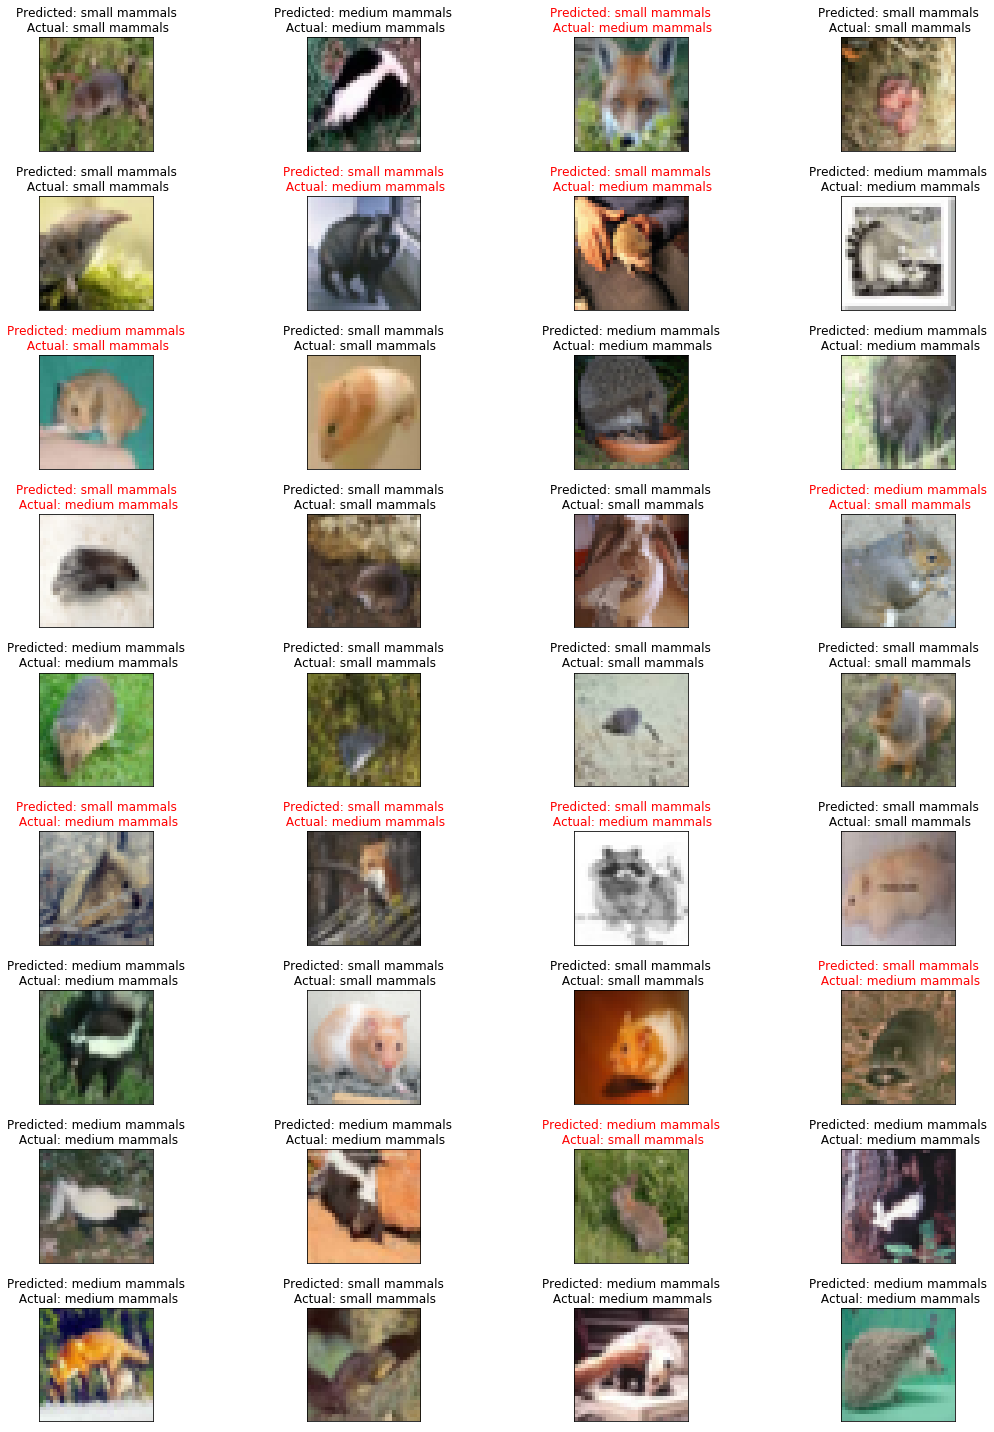

In [0]:
# Visualize 36 random images with original and predicted labels
%%time
cifar_grid(predict_lr)

####**Confusion matrix and classification report for Logistic Regression**

In [0]:
# Method 1 - Simple confusion matrix
%%time
conf_mat1 = predict_lr.select("binary_index","prediction")
print (conf_mat1.rdd.zipWithIndex().countByKey())

defaultdict(<class 'int'>, {Row(binary_index=0.0, prediction=1.0): 145, Row(binary_index=1.0, prediction=1.0): 296, Row(binary_index=0.0, prediction=0.0): 411, Row(binary_index=1.0, prediction=0.0): 291})
CPU times: user 39.5 ms, sys: 7.61 ms, total: 47.2 ms
Wall time: 3min 47s


In [0]:
# Method 2 - use multi-class matrics to print the confusion matrix
%%time
predictionRDD_1 = predict_lr.select(['binary_index', 'prediction']) \
                            .rdd.map(lambda line: (line[1], line[0]))
metrics1 = MulticlassMetrics(predictionRDD_1)


cm1 = metrics1.confusionMatrix().toArray()
print("Confusion Matrix:")
print("%10s %12s %12s" % ("real\pred" ,"predicted 0", "predicted 1"))
for i in range (0,2):
  print("real %2s" % i, end='')
  for j in range (0,2):
    print("%12d" % cm1[i][j], end='')
  print()

Confusion Matrix:
 real\pred  predicted 0  predicted 1
real  0         411         145
real  1         291         296
CPU times: user 40.6 ms, sys: 7.87 ms, total: 48.5 ms
Wall time: 3min 45s


In [0]:
# Print the classification report with precision, recall, f1-score and support
%%time
def cr1(label_in):
  precision = metrics1.precision(label=label_in)
  recall = metrics1.recall(label=label_in)
  F1_Measure = metrics1.fMeasure(label=label_in)
  support = test_df.filter(test_df.binary_index==label_in).count()
  print("%10s %12.2f  %12.2f %12.2f %12d" % \
        (label_in,precision, recall, F1_Measure, support))

print("            Classification Report")
print("%10s %12s  %12s %12s %12s"    % ("label","precision","recall","f1-score","support"))
for i in np.arange(0.0, 2.0, 1.0):
  cr1(i)

            Classification Report
     label    precision        recall     f1-score      support
       0.0         0.59          0.74         0.65          556
       1.0         0.67          0.50         0.58          587
CPU times: user 54.9 ms, sys: 11.7 ms, total: 66.6 ms
Wall time: 7min 34s


##**Model 2** - Naive Bayes Classifier

In [0]:
# Import the necessary package(s)
%%time
from pyspark.ml.classification import NaiveBayes

CPU times: user 21 µs, sys: 6 µs, total: 27 µs
Wall time: 31.2 µs


In [0]:
# Create a Naive bayes classifier-based model, fit, predict and print relevant columns from the first 10 rows
%%time
naive_bayes = NaiveBayes(featuresCol="features", labelCol="binary_index",smoothing=1.0, modelType="multinomial")
naive_bayes = naive_bayes.fit(train_df)
predict_nb = naive_bayes.transform(test_df)
predict_nb.select("coarse","binary_index","prediction","probability").show(10)

+--------------+------------+----------+--------------------+
|        coarse|binary_index|prediction|         probability|
+--------------+------------+----------+--------------------+
| small_mammals|         0.0|       1.0|[0.04699485125869...|
|medium_mammals|         1.0|       1.0|[0.37349437754014...|
| small_mammals|         0.0|       1.0|[0.49742404147437...|
| small_mammals|         0.0|       0.0|[0.60447148053640...|
|medium_mammals|         1.0|       1.0|[0.08935989872676...|
|medium_mammals|         1.0|       0.0|[0.99281403497744...|
|medium_mammals|         1.0|       1.0|[0.00413106018955...|
|medium_mammals|         1.0|       0.0|[0.98257673622296...|
|medium_mammals|         1.0|       1.0|[1.38216751282667...|
|medium_mammals|         1.0|       0.0|[0.65504292132605...|
+--------------+------------+----------+--------------------+
only showing top 10 rows

CPU times: user 37.9 ms, sys: 10.5 ms, total: 48.4 ms
Wall time: 3min 26s


In [0]:
# Print the prediction score / accuracy
%%time
accuracy2 = (eval.evaluate(predict_nb))*100
print("Model Accuracy: %.3f%%" % accuracy2)

Model Accuracy: 60.152%
CPU times: user 14.1 ms, sys: 4.33 ms, total: 18.5 ms
Wall time: 1min 53s


CPU times: user 510 ms, sys: 11.9 ms, total: 522 ms
Wall time: 1min 54s


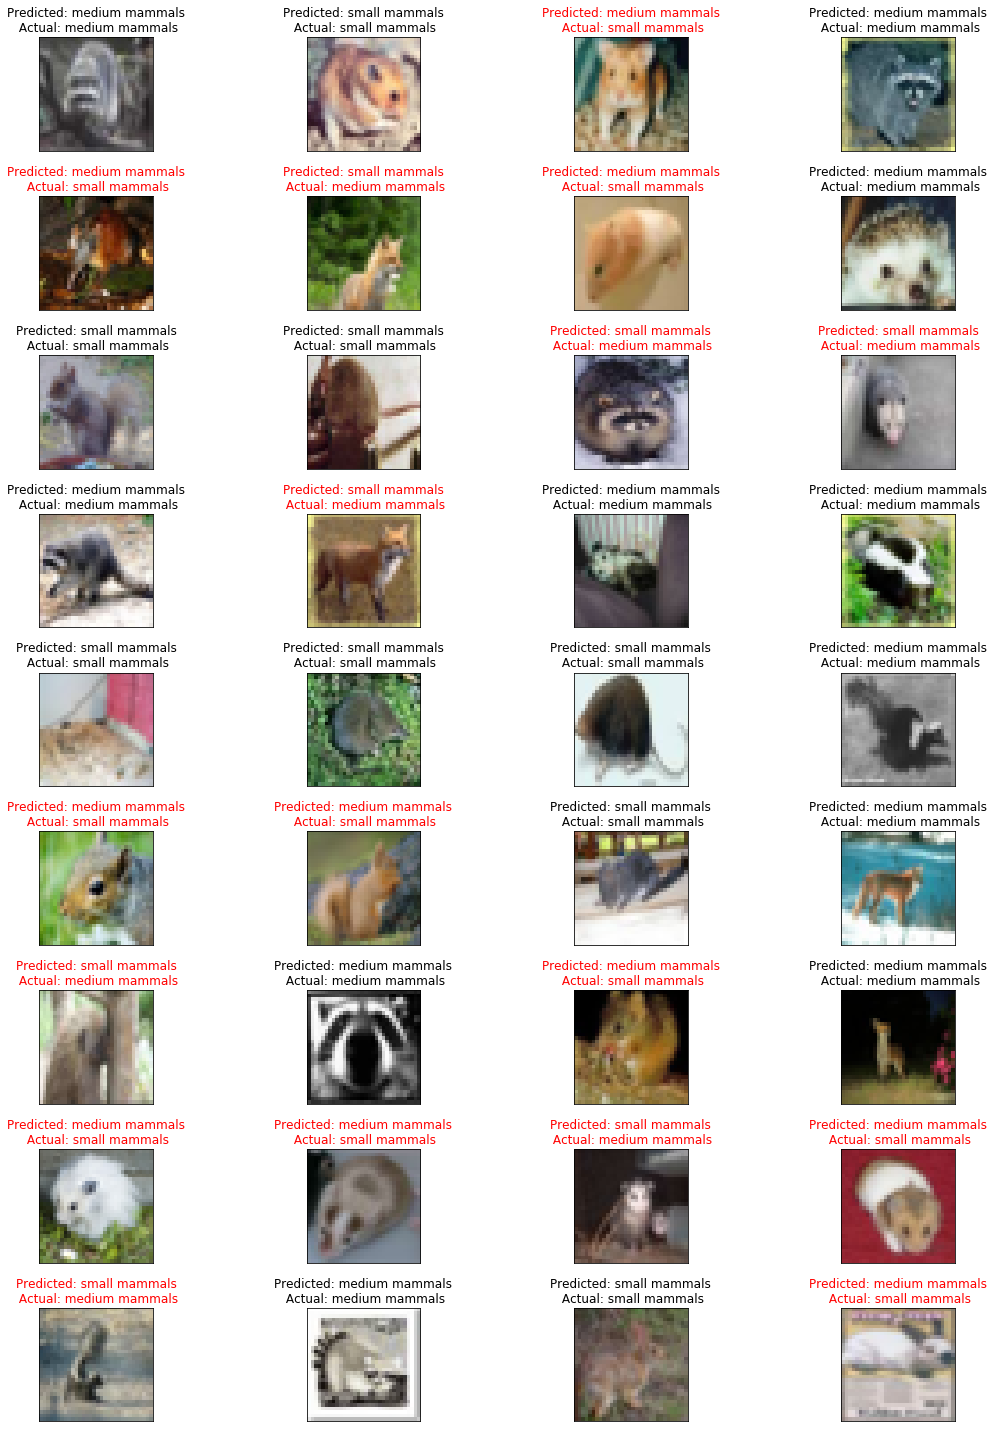

In [0]:
# Visualize 36 random images with original and predicted labels
%%time
cifar_grid(predict_nb)

####**Confusion matrix and classification report for Naive Bayes Classifier**

In [0]:
# Method 1 - Simple confusion matrix
%%time
conf_mat2 = predict_nb.select("binary_index","prediction")
print(conf_mat2.rdd.zipWithIndex().countByKey())

defaultdict(<class 'int'>, {Row(binary_index=0.0, prediction=1.0): 212, Row(binary_index=1.0, prediction=1.0): 343, Row(binary_index=0.0, prediction=0.0): 344, Row(binary_index=1.0, prediction=0.0): 244})
CPU times: user 38 ms, sys: 6.84 ms, total: 44.9 ms
Wall time: 3min 47s


In [0]:
# Method 2 - use multi-class matrics to print the confusion matrix
%%time
predictionRDD2 = predict_nb.select(['binary_index', 'prediction']) \
                            .rdd.map(lambda line: (line[1], line[0]))
metrics2 = MulticlassMetrics(predictionRDD2)

cm2 = metrics2.confusionMatrix().toArray()
print("Confusion Matrix:")
print("%10s %12s %12s" % ("real\pred" ,"predicted 0", "predicted 1"))
for i in range (0,2):
  print("real %2s" % i, end='')
  for j in range (0,2):
    print("%12d" % cm2[i][j], end='')
  print()

Confusion Matrix:
 real\pred  predicted 0  predicted 1
real  0         344         212
real  1         244         343
CPU times: user 37.1 ms, sys: 5.48 ms, total: 42.6 ms
Wall time: 3min 46s


In [0]:
# Print the classification report with precision, recall, f1-score and support
%%time
def cr2(label_in):
  precision = metrics2.precision(label=label_in)
  recall = metrics2.recall(label=label_in)
  F1_Measure = metrics2.fMeasure(label=label_in)
  support = test_df.filter(test_df.binary_index==label_in).count()
  print("%10s %12.2f  %12.2f %12.2f %12d" % \
        (label_in,precision, recall, F1_Measure, support))

print("            Classification Report")
print("%10s %12s  %12s %12s %12s"    % ("label","precision","recall","f1-score","support"))
for i in np.arange(0.0, 2.0, 1.0):
  cr2(i)

            Classification Report
     label    precision        recall     f1-score      support
       0.0         0.59          0.62         0.60          556
       1.0         0.62          0.58         0.60          587
CPU times: user 54.1 ms, sys: 10.5 ms, total: 64.6 ms
Wall time: 7min 32s


##**Model 3** - Random Forest Classifier

In [0]:
# Import the necessary package(s)
%%time
from pyspark.ml.classification import RandomForestClassifier

CPU times: user 15 µs, sys: 3 µs, total: 18 µs
Wall time: 21.7 µs


In [0]:
# Create a Random Forest classifer-based model, fit, predict and print relevant columns from the first 10 rows
%%time
rfc=RandomForestClassifier(featuresCol="features", labelCol="binary_index",numTrees=100)
rfc_model=rfc.fit(train_df)
predict_rfc=rfc_model.transform(test_df)
predict_rfc.select("coarse","binary_index","prediction","probability").show(10)

+--------------+------------+----------+--------------------+
|        coarse|binary_index|prediction|         probability|
+--------------+------------+----------+--------------------+
| small_mammals|         0.0|       1.0|[0.42639967486582...|
|medium_mammals|         1.0|       1.0|[0.40047711656559...|
| small_mammals|         0.0|       1.0|[0.40378258534409...|
| small_mammals|         0.0|       0.0|[0.58306437952565...|
|medium_mammals|         1.0|       1.0|[0.36524324188417...|
|medium_mammals|         1.0|       1.0|[0.47979863800225...|
|medium_mammals|         1.0|       1.0|[0.38130255119385...|
|medium_mammals|         1.0|       1.0|[0.48739366968345...|
|medium_mammals|         1.0|       1.0|[0.26917420297434...|
|medium_mammals|         1.0|       1.0|[0.38101134487990...|
+--------------+------------+----------+--------------------+
only showing top 10 rows

CPU times: user 74.2 ms, sys: 16.8 ms, total: 91 ms
Wall time: 8min 20s


In [0]:
# Print the prediction score / accuracy
%%time
accuracy3 = (eval.evaluate(predict_rfc))*100
print("Model Accuracy: %.3f%%" % accuracy3)

Model Accuracy: 65.760%
CPU times: user 14.1 ms, sys: 4.67 ms, total: 18.8 ms
Wall time: 1min 53s


CPU times: user 941 ms, sys: 3.3 ms, total: 944 ms
Wall time: 1min 54s


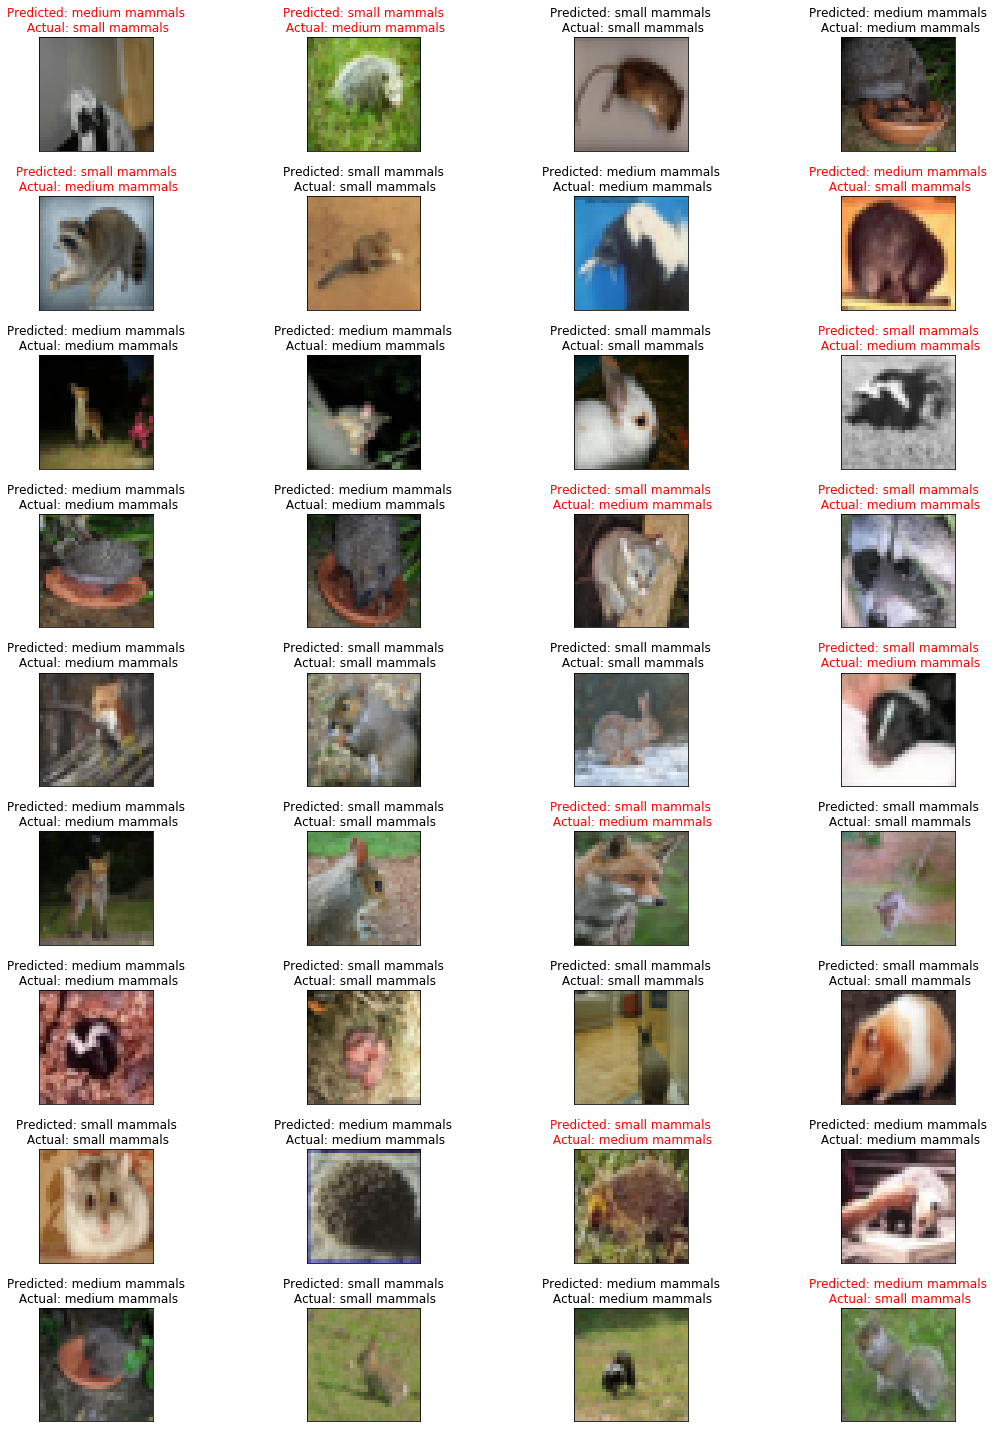

In [0]:
# Visualize 36 random images with original and predicted labels
%%time
cifar_grid(predict_rfc)

####**Confusion matrix and classification report for Random Forest Classifier**

In [0]:
# Method 1 - Simple confusion matrix
%%time
conf_mat3 = predict_rfc.select("binary_index","prediction")
print (conf_mat3.rdd.zipWithIndex().countByKey())

defaultdict(<class 'int'>, {Row(binary_index=0.0, prediction=1.0): 179, Row(binary_index=1.0, prediction=1.0): 374, Row(binary_index=0.0, prediction=0.0): 377, Row(binary_index=1.0, prediction=0.0): 213})
CPU times: user 32.4 ms, sys: 11 ms, total: 43.4 ms
Wall time: 3min 46s


In [0]:
# Method 2 - use multi-class matrics to print the confusion matrix
%%time
predictionRDD3 = predict_rfc.select(['binary_index', 'prediction']) \
                            .rdd.map(lambda line: (line[1], line[0]))
metrics3 = MulticlassMetrics(predictionRDD3)


cm3 = metrics3.confusionMatrix().toArray()
print("Confusion Matrix:")
print("%10s %12s %12s" % ("real\pred" ,"predicted 0", "predicted 1"))
for i in range (0,2):
  print("real %2s" % i, end='')
  for j in range (0,2):
    print("%12d" % cm3[i][j], end='')
  print()

Confusion Matrix:
 real\pred  predicted 0  predicted 1
real  0         377         179
real  1         213         374
CPU times: user 34 ms, sys: 6.41 ms, total: 40.4 ms
Wall time: 3min 46s


In [0]:
# Print the classification report with precision, recall, f1-score and support
%%time
def cr3(label_in):
  precision = metrics3.precision(label=label_in)
  recall = metrics3.recall(label=label_in)
  F1_Measure = metrics3.fMeasure(label=label_in)
  support = test_df.filter(test_df.binary_index==label_in).count()
  print("%10s %12.2f  %12.2f %12.2f %12d" % \
        (label_in,precision, recall, F1_Measure, support))

print("            Classification Report")
print("%10s %12s  %12s %12s %12s"    % ("label","precision","recall","f1-score","support"))
for i in np.arange(0.0, 2.0, 1.0):
  cr3(i)

            Classification Report
     label    precision        recall     f1-score      support
       0.0         0.64          0.68         0.66          556
       1.0         0.68          0.64         0.66          587
CPU times: user 50.4 ms, sys: 14.3 ms, total: 64.6 ms
Wall time: 7min 30s


# **Prediction on one testing subclass images from each of the two superclasses**

* Fine label aka subclass refers to an organism, such as Rabbit, fox, mouse etc.
* Course label aka superclass refers to their categorization, such as small and medium mammals.
* Each pair has one subclass each from small & medium mammals.

4 pairs comprising of 4 subclasses each from small and large mammals are set as training set, and the missing excluded pair (1 subclass each from small and large mammals) is set as testing set. As there are 5 subclasses each in small and large mammals, we will generate a list of 25 pairs with different combinations, each with 4 pairs as train set and 1 pair as test set.

##**Part 1:** Data Preparation (Ching-min & Dandan)

In [0]:
# Create a new datafrane with new columns
%%time
target_name_df2 = target_df.withColumn("coarse", udf(lambda coarse_label: coarse_labels[coarse_label],\
                                                    StringType())(target_df['coarse_labels'])) \
                          .withColumn("fine", udf(lambda fine_label: fine_labels[fine_label], \
                                                  StringType())(target_df['fine_labels']))

CPU times: user 8.62 ms, sys: 2.14 ms, total: 10.8 ms
Wall time: 32.2 ms


In [0]:
# Change the coarse label of training set into a binary label, and check the distinct binary labels
%%time
stringindexer = StringIndexer(inputCol='coarse_labels', outputCol='binary_index')
target_name_df2 = stringindexer.fit(target_name_df2).transform(target_name_df2)
target_name_df2.select('binary_index').distinct().collect()

CPU times: user 49.6 ms, sys: 15.4 ms, total: 65 ms
Wall time: 3min 45s


In [0]:
# Rename data as features and re-order columns 
%%time
target_name_df2 = target_name_df2.withColumnRenamed("data","features").select("features","binary_index", "coarse_labels","coarse","fine_labels","fine")

CPU times: user 1.9 ms, sys: 2.26 ms, total: 4.16 ms
Wall time: 24.2 ms


In [0]:
# Verify the data type
%%time
target_name_df2.dtypes

CPU times: user 1.61 ms, sys: 0 ns, total: 1.61 ms
Wall time: 2.68 ms


[('features', 'vector'),
 ('binary_index', 'double'),
 ('coarse_labels', 'bigint'),
 ('coarse', 'string'),
 ('fine_labels', 'bigint'),
 ('fine', 'string')]

In [0]:
# Check the distinct labels
%%time
print("Distinct labels in the training set -", target_name_df2.select('coarse_labels','binary_index','coarse','fine_labels','fine').distinct().collect())

Distinct labels in the training set - [Row(coarse_labels=16, binary_index=0.0, coarse='small_mammals', fine_labels=74, fine='shrew'), Row(coarse_labels=16, binary_index=0.0, coarse='small_mammals', fine_labels=80, fine='squirrel'), Row(coarse_labels=16, binary_index=0.0, coarse='small_mammals', fine_labels=50, fine='mouse'), Row(coarse_labels=12, binary_index=1.0, coarse='medium_mammals', fine_labels=63, fine='porcupine'), Row(coarse_labels=12, binary_index=1.0, coarse='medium_mammals', fine_labels=66, fine='raccoon'), Row(coarse_labels=12, binary_index=1.0, coarse='medium_mammals', fine_labels=64, fine='possum'), Row(coarse_labels=12, binary_index=1.0, coarse='medium_mammals', fine_labels=34, fine='fox'), Row(coarse_labels=16, binary_index=0.0, coarse='small_mammals', fine_labels=36, fine='hamster'), Row(coarse_labels=16, binary_index=0.0, coarse='small_mammals', fine_labels=65, fine='rabbit'), Row(coarse_labels=12, binary_index=1.0, coarse='medium_mammals', fine_labels=75, fine='skun

We are skipping the check for null values as it was performed earlier. It is also very time-consuming.

In [0]:
# Store different missing pair of rdd
# Each list of rdd will have 25 different sets
%%time
train_list=[]
test_list=[]
test_label_list=spark.sparkContext.parallelize(())

CPU times: user 477 µs, sys: 1.14 ms, total: 1.62 ms
Wall time: 6.25 ms


In [0]:
# Fetch the fine labels of small and medium mammals
%%time
medium_sized_mammals_ind = [fine_labels.index(x) for x in ['fox', 'porcupine', 'possum', 'raccoon', 'skunk'] ]
small_mammals_ind = [fine_labels.index(x) for x in ['hamster', 'mouse', 'rabbit', 'shrew', 'squirrel'] ]

CPU times: user 56 µs, sys: 0 ns, total: 56 µs
Wall time: 176 µs


In [0]:
# Create a loop to generate 25 pairs of train set with 4 pairs each of small and large mammals, and remaining 2 pairs as test set.
%%time
for a in medium_sized_mammals_ind:
    for b in small_mammals_ind :
        # test
        test_filter=target_name_df2.filter((target_name_df2.fine_labels==a) | (target_name_df2.fine_labels==b)) # extract the rows of missimg pair
        
        
        # train
        train_filter=target_name_df2.filter((target_name_df2.fine_labels!=a) & (target_name_df2.fine_labels!=b)) # extract the rows of else
        
        
        # add to list
        train_list.append(train_filter)
        test_list.append(test_filter)
        
        # test list
        temp=spark.sparkContext.parallelize([(fine_labels[a],fine_labels[b])])
        test_label_list=test_label_list.union(temp)

CPU times: user 109 ms, sys: 13.4 ms, total: 122 ms
Wall time: 762 ms


## Study the training data

In [0]:
# Check the length of training list, which gives the number of training sets
%%time
len(train_list)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.3 µs


25

In [0]:
# First 5 rows of train_list[0]
%%time
train_list[0].show(5)

+--------------------+------------+-------------+--------------+-----------+--------+
|            features|binary_index|coarse_labels|        coarse|fine_labels|    fine|
+--------------------+------------+-------------+--------------+-----------+--------+
|[0.27843137254901...|         0.0|           16| small_mammals|         80|squirrel|
|[0.61176470588235...|         0.0|           16| small_mammals|         74|   shrew|
|[0.96078431372549...|         1.0|           12|medium_mammals|         64|  possum|
|[1.0,1.0,1.0,1.0,...|         1.0|           12|medium_mammals|         64|  possum|
|[0.11764705882352...|         0.0|           16| small_mammals|         65|  rabbit|
+--------------------+------------+-------------+--------------+-----------+--------+
only showing top 5 rows

CPU times: user 6.04 ms, sys: 971 µs, total: 7.01 ms
Wall time: 45.3 s


In [0]:
# Check the type of file
%%time
type(train_list[0])

CPU times: user 6 µs, sys: 1e+03 ns, total: 7 µs
Wall time: 11.4 µs


pyspark.sql.dataframe.DataFrame

In [0]:
# Check the statistical features
%%time
train_list[0].describe().show()

+-------+------------------+------------------+--------------+-----------------+--------+
|summary|      binary_index|     coarse_labels|        coarse|      fine_labels|    fine|
+-------+------------------+------------------+--------------+-----------------+--------+
|  count|              4800|              4800|          4800|             4800|    4800|
|   mean|               0.5|              14.0|          null|           67.125|    null|
| stddev|0.5000520914727675|2.0002083658910697|          null|8.667469414257729|    null|
|    min|               0.0|                12|medium_mammals|               50|   mouse|
|    max|               1.0|                16| small_mammals|               80|squirrel|
+-------+------------------+------------------+--------------+-----------------+--------+

CPU times: user 13.1 ms, sys: 3.82 ms, total: 16.9 ms
Wall time: 1min 53s


## Study the testing data

In [0]:
# First 5 rows of test_list[0]
%%time
test_list[0].show(5)

+--------------------+------------+-------------+--------------+-----------+-------+
|            features|binary_index|coarse_labels|        coarse|fine_labels|   fine|
+--------------------+------------+-------------+--------------+-----------+-------+
|[0.23529411764705...|         0.0|           16| small_mammals|         36|hamster|
|[0.14117647058823...|         0.0|           16| small_mammals|         36|hamster|
|[0.48235294117647...|         1.0|           12|medium_mammals|         34|    fox|
|[0.71764705882352...|         0.0|           16| small_mammals|         36|hamster|
|[0.78431372549019...|         1.0|           12|medium_mammals|         34|    fox|
+--------------------+------------+-------------+--------------+-----------+-------+
only showing top 5 rows

CPU times: user 6.97 ms, sys: 717 µs, total: 7.68 ms
Wall time: 45.5 s


In [0]:
# Check the type of file
%%time
type(test_list[0])

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 9.06 µs


pyspark.sql.dataframe.DataFrame

In [0]:
# Check the statistical features
%%time
test_list[0].describe().show()

+-------+------------------+------------------+--------------+------------------+-------+
|summary|      binary_index|     coarse_labels|        coarse|       fine_labels|   fine|
+-------+------------------+------------------+--------------+------------------+-------+
|  count|              1200|              1200|          1200|              1200|   1200|
|   mean|               0.5|              14.0|          null|              35.0|   null|
| stddev|0.5002084636321551|2.0008338545286213|          null|1.0004169272643104|   null|
|    min|               0.0|                12|medium_mammals|                34|    fox|
|    max|               1.0|                16| small_mammals|                36|hamster|
+-------+------------------+------------------+--------------+------------------+-------+

CPU times: user 13.1 ms, sys: 3.18 ms, total: 16.3 ms
Wall time: 1min 52s


In [0]:
# Print the missing pair list
%%time
test_label_list.collect() 

CPU times: user 3.51 ms, sys: 102 µs, total: 3.62 ms
Wall time: 88.5 ms


[('fox', 'hamster'),
 ('fox', 'mouse'),
 ('fox', 'rabbit'),
 ('fox', 'shrew'),
 ('fox', 'squirrel'),
 ('porcupine', 'hamster'),
 ('porcupine', 'mouse'),
 ('porcupine', 'rabbit'),
 ('porcupine', 'shrew'),
 ('porcupine', 'squirrel'),
 ('possum', 'hamster'),
 ('possum', 'mouse'),
 ('possum', 'rabbit'),
 ('possum', 'shrew'),
 ('possum', 'squirrel'),
 ('raccoon', 'hamster'),
 ('raccoon', 'mouse'),
 ('raccoon', 'rabbit'),
 ('raccoon', 'shrew'),
 ('raccoon', 'squirrel'),
 ('skunk', 'hamster'),
 ('skunk', 'mouse'),
 ('skunk', 'rabbit'),
 ('skunk', 'shrew'),
 ('skunk', 'squirrel')]

## **Part2:** Model creation (Megha & Rajasree)



In [0]:
# Import the packages
import time
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator as BCE

In [0]:
# Verify the Schema
%%time
train_list[0].printSchema()

root
 |-- features: vector (nullable = true)
 |-- binary_index: double (nullable = false)
 |-- coarse_labels: long (nullable = true)
 |-- coarse: string (nullable = true)
 |-- fine_labels: long (nullable = true)
 |-- fine: string (nullable = true)

CPU times: user 966 µs, sys: 187 µs, total: 1.15 ms
Wall time: 2.72 ms


In [0]:
# Verify the Schema
%%time
test_list[0].printSchema()

root
 |-- features: vector (nullable = true)
 |-- binary_index: double (nullable = false)
 |-- coarse_labels: long (nullable = true)
 |-- coarse: string (nullable = true)
 |-- fine_labels: long (nullable = true)
 |-- fine: string (nullable = true)

CPU times: user 1.28 ms, sys: 0 ns, total: 1.28 ms
Wall time: 3.21 ms


In [0]:
"""# Let us view the values stored - excluding as it takes 1.5 hours
%%time
for i in range(0,25):
  print("Trial",i, "->\t Testing set:")
  print(test_list[i].groupby('fine','coarse').count().show())
  print ("\t\t Training set:")
  print(train_list[i].groupby('fine','coarse').count().show(),"\n")

  # Can do orderBy too."""

'# Let us view the values stored - excluding as it takes 1.5 hours\n%%time\nfor i in range(0,25):\n  print("Trial",i, "->\t Testing set:")\n  print(test_list[i].groupby(\'fine\',\'coarse\').count().show())\n  print ("\t\t Training set:")\n  print(train_list[i].groupby(\'fine\',\'coarse\').count().show(),"\n")\n\n  # Can do orderBy too.'

In [0]:
# Check for distinct labels in one trial
%%time
test_list[0].select('fine_labels','fine','coarse').distinct().show()

+-----------+-------+--------------+
|fine_labels|   fine|        coarse|
+-----------+-------+--------------+
|         36|hamster| small_mammals|
|         34|    fox|medium_mammals|
+-----------+-------+--------------+

CPU times: user 35.4 ms, sys: 5.8 ms, total: 41.2 ms
Wall time: 1min 53s


In [0]:
# Check for distinct labels in one trial
%%time
train_list[0].select('fine_labels','fine','coarse').distinct().show()

+-----------+---------+--------------+
|fine_labels|     fine|        coarse|
+-----------+---------+--------------+
|         63|porcupine|medium_mammals|
|         50|    mouse| small_mammals|
|         66|  raccoon|medium_mammals|
|         75|    skunk|medium_mammals|
|         65|   rabbit| small_mammals|
|         64|   possum|medium_mammals|
|         74|    shrew| small_mammals|
|         80| squirrel| small_mammals|
+-----------+---------+--------------+

CPU times: user 33.9 ms, sys: 7.59 ms, total: 41.5 ms
Wall time: 1min 52s


##**Logistic Regression**

In [0]:
%%time
lr_accuracy=list()
lr_time=list()
print("Logistic Regression -") 

# Create a 'for' loop to generate 25 trials
for i in range(0,25):
  start = time.time()

  """ Can include pca and Label indexer to convert coarse label into a binary label, and choosing 
  principal features. Below is the code. We are excluding this as it is time-consuming and colab
  gets stuck.
  labelIndexer = StringIndexer(inputCol="coarse", outputCol="binary").fit(train_list[i])
  pca = PCA(k=3, inputCol="features", outputCol="pcaFeatures").fit(train_list[i])
  logreg = LogisticRegression(labelCol="binary", featuresCol="featpcaFeaturesures",maxIter=10)
  pipeline_cv1 = Pipeline(stages = [pca, labelIndexer,logreg])                
  """
  
  # Instantiate the model
  logreg = LogisticRegression(labelCol="binary_index", featuresCol="features",maxIter=10)

  # Create a pipeline
  pipeline_cv1 = Pipeline(stages = [logreg])

  # Create a parameter grid
  paramGrid = ParamGridBuilder() \
      .addGrid(logreg.regParam, [0.01,0.1]) \
      .build()

  # Perform cross-validation
  crossval = CrossValidator(estimator = pipeline_cv1,
                            estimatorParamMaps=paramGrid,
                            evaluator = BCE(labelCol = "binary_index",\
                                            rawPredictionCol = "prediction",\
                                            metricName = "areaUnderROC"),
                            numFolds= 3)
  
  # Fit and predict using the model
  cv_model = crossval.fit(train_list[i])
  predictions = cv_model.transform(test_list[i])

  # Print the prediction score / accuracy
  evaluator=BinaryClassificationEvaluator(labelCol="binary_index", rawPredictionCol= "prediction")
  accuracy = evaluator.evaluate(predictions)
  print ("Trial",i, " -> Accuracy with test pair {} is: {:.2f}%".format(test_label_list.collect()[i],accuracy*100)) 

  # Calculate the time taken
  end = time.time()
  print('Time taken: {:.2f} minutes \n'.format((end - start)/60))

  # Append the accuracy and time taken during each trial
  lr_accuracy.append(accuracy)
  lr_time.append(end-start)

Logistic Regression -
Trial 0  -> Accuracy with test pair ('fox', 'hamster') is: 50.42%
Time taken: 13.03 minutes 

Trial 1  -> Accuracy with test pair ('fox', 'mouse') is: 44.33%
Time taken: 16.03 minutes 



In [0]:
# Print the average accuracy and time
%%time
print("Average accuracy: {:.2f}%".format(np.mean(lr_accuracy)*100))
print("Average time: {:.2f} minutes\n".format(np.mean(lr_time)/60))

In [0]:
# Print statistics such as mean, standard deviation, minimum, maximum and quantiles

%%time
import numpy as np
# Mean or average
print("The statistics for the 25 trials using Logistic Regression->\
       \n\nMean accuracy: {:.2f}%".format(np.mean(lr_accuracy)*100))

# Standard deviation
print("Standard deviation: {:.2f}%".format(np.std(lr_accuracy)*100))

# Mininmum
print("Minimum Accuracy: {:.2f}%".format(np.min(lr_accuracy)*100))

# Maximum
print("Maximum accuracy: {:.2f}%".format(np.max(lr_accuracy)*100))

# 1st quantile or 25 percentile
print("25% (1st quantile) accuracy: {:.2f}%".format(np.percentile(lr_accuracy, 25)*100))

# 2nd quantile or 50 percentile or median
print("50% (median or 2nd quantile) accuracy: {:.2f}%".format(np.percentile(lr_accuracy, 50)*100))

# 3rd quantile or 75 percentile 
print("75% (3rd quantile) accuracy: {:.2f}%".format(np.percentile(lr_accuracy, 75)*100),"\n")

## **Random Forest classifier**

In [0]:
%%time
rfc_accuracy=list()
rfc_time=list()
print("Random Forest Classifier -") 

# Create a 'for' loop to generate 25 trials
for i in range(0,25):
  start = time.time()

  """ Can include pca and Label indexer to convert coarse label into a binary label, and choosing 
  principal features. Below is the code. We are excluding this as it is time-consuming and colab
  gets stuck.
  labelIndexer = StringIndexer(inputCol="coarse", outputCol="binary").fit(train_list[i])
  pca = PCA(k=3, inputCol="features", outputCol="pcaFeatures").fit(train_list[i])
  rfc=RandomForestClassifier(labelCol="binary", featuresCol="featpcaFeaturesures",maxIter=10)
  pipeline_cv1 = Pipeline(stages = [pca, labelIndexer,rfc])                
  """"
    
  # Instantiate the model
  rfc=RandomForestClassifier(featuresCol="features", labelCol="binary_index")

  # Create a pipeline
  pipeline_cv2 = Pipeline(stages = [rfc])

  # Create a parameter grid
  paramGrid = ParamGridBuilder() \
      .addGrid(rfc.numTrees, [25,50,75,100]) \
      .build()

  # Perform cross-validation
  crossval = CrossValidator(estimator = pipeline_cv2,
                            estimatorParamMaps=paramGrid,
                            evaluator = BCE(labelCol = "binary_index",\
                                            rawPredictionCol = "prediction",\
                                            metricName = "areaUnderROC"),
                            numFolds= 3)
  
  # Fit and predict using the model
  cv_model = crossval.fit(train_list[i])
  predictions = cv_model.transform(test_list[i])

  # Print the prediction score / accuracy
  evaluator=BinaryClassificationEvaluator(labelCol="binary_index", rawPredictionCol= "prediction")
  accuracy = evaluator.evaluate(predictions)
  print ("Trial",i, " -> Accuracy with test pair {} is: {:.2f}%".format(test_label_list.collect()[i],accuracy*100)) 

  # Calculate the time taken
  end = time.time()
  print('Time taken: {:.2f} minutes \n'.format((end - start)/60))

  # Append the accuracy and time taken during each trial
  rfc_accuracy.append(accuracy)
  rfc_time.append(end-start)

In [0]:
# Print the average accuracy and time
%%time
print("Average accuracy: {:.2f}%".format(np.mean(rfc_accuracy)*100))
print("Average time: {:.2f} minutes\n".format(np.mean(rfc_time)/60))

In [0]:
# Print statistics such as mean, standard deviation, minimum, maximum and quantiles

%%time
import numpy as np
# Mean or average
print("The statistics for the 25 trials using Random forest classifier->\
       \n\nMean accuracy: {:.2f}%".format(np.mean(rfc_accuracy)*100))

# Standard deviation
print("Standard deviation: {:.2f}%".format(np.std(rfc_accuracy)*100))

# Mininmum
print("Minimum Accuracy: {:.2f}%".format(np.min(rfc_accuracy)*100))

# Maximum
print("Maximum accuracy: {:.2f}%".format(np.max(rfc_accuracy)*100))

# 1st quantile or 25 percentile
print("25% (1st quantile) accuracy: {:.2f}%".format(np.percentile(rfc_accuracy, 25)*100))

# 2nd quantile or 50 percentile or median
print("50% (median or 2nd quantile) accuracy: {:.2f}%".format(np.percentile(rfc_accuracy, 50)*100))

# 3rd quantile or 75 percentile 
print("75% (3rd quantile) accuracy: {:.2f}%".format(np.percentile(rfc_accuracy, 75)*100),"\n")